# tabular-playground-series-jan-2022 Modeling
- データに関する知見だけでなく、データ分析の基礎的な方法をコメントで残す形とする

## 1. Import libralies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import itertools

from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

sns.set(style='white', context='notebook', palette='pastel')

## 2. Load processed data

In [3]:
# Load data
#train = pd.read_csv('../data/processed/train_v1_label.csv', index_col=0)
#test = pd.read_csv('../data/processed/test_v1_label.csv', index_col=0)
train = pd.read_csv('../data/processed/train_v2_onehot.csv', index_col=0)
test = pd.read_csv('../data/processed/test_v2_onehot.csv', index_col=0)
#train = pd.read_csv('../data/processed/train_v3_onehot_economy.csv', index_col=0)
#test = pd.read_csv('../data/processed/test_v3_onehot_economy.csv', index_col=0)

train['num_sold'] = train['num_sold'].astype(int)
Y_train = train['num_sold']
X_train = train.drop(columns=['num_sold'])
"""
train['num_sold_base'] = train['num_sold_base'].astype(int)
Y_train = train['num_sold_base']
X_train = train.drop(columns=['num_sold', 'num_sold_base'])
"""
raw_test = pd.read_csv("../data/raw/test.csv")
test_id = raw_test['row_id']

In [4]:
X_train.head()

,year,month,day,dayofweek,country_Finland,country_Norway,country_Sweden,store_KaggleMart,store_KaggleRama,product_Kaggle Hat,product_Kaggle Mug,product_Kaggle Sticker
0,2015,1,1,3,1,0,0,1,0,0,1,0
1,2015,1,1,3,1,0,0,1,0,1,0,0
2,2015,1,1,3,1,0,0,1,0,0,0,1
3,2015,1,1,3,1,0,0,0,1,0,1,0
4,2015,1,1,3,1,0,0,0,1,1,0,0


## 3. Training Setting

### 3.1 define setting parameters
Cross validate models

In [5]:
# 再現性確保のためのrandom_state の設定
random_state = 43

# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)

### 3.2 define evaluation

In [6]:
def calc_smape_score(true, pred):
    """SMAPEを計算する

    true (np.array) : 実測値
    pred (np.array) : 予測値

    np.array        : smapeの計算結果
    """

    return 100 / len(true) * np.sum(2 * np.abs(pred - true) / (np.abs(pred) + np.abs(true)))


In [7]:
scoring_smape = make_scorer(calc_smape_score, greater_is_better=False)

score_funcs = {
    'smape': scoring_smape,
    'R2': make_scorer(r2_score, greater_is_better=True),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
}

### 3.3 split datasets

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=random_state)
print(x_train.shape)
print(x_test.shape)

(18408, 12)
(7890, 12)


In [9]:
x_train.head()

,year,month,day,dayofweek,country_Finland,country_Norway,country_Sweden,store_KaggleMart,store_KaggleRama,product_Kaggle Hat,product_Kaggle Mug,product_Kaggle Sticker
16917,2017,7,28,4,0,0,1,0,1,0,1,0
22610,2018,6,10,6,1,0,0,1,0,0,0,1
20263,2018,1,30,1,0,0,1,1,0,1,0,0
6332,2015,12,18,4,0,0,1,1,0,0,0,1
6209,2015,12,11,4,0,0,1,0,1,0,0,1


## 4. Modeling

### 4.1 model setting

In [10]:
# LightGBM
LGBM = LGBMRegressor(random_state=random_state,
                     boosting_type='gbdt',
                     objective='regression',
                     n_estimators=3000,
                     )

### 4.2 Baseline result
- パラメータサーチなし
- cross validationのみ実施

In [11]:
scores = cross_validate(LGBM, x_train, y_train, cv=kfold, scoring=score_funcs)
scores

/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


{'fit_time': array([2.59124494, 1.610044  , 1.17268109, 1.3368001 ]),
 'score_time': array([0.29350924, 0.29412699, 0.2264092 , 0.25408196]),
 'test_smape': array([-5.17434333, -5.1542278 , -5.26949676, -5.214135  ]),
 'test_R2': array([0.98688465, 0.98565576, 0.98553321, 0.98656861]),
 'test_MSE': array([ -895.85187818, -1003.74989836, -1020.48210813,  -938.30306622])}

In [12]:
mean_smape = scores['test_smape'].mean() * (-1)
print('SMAPE:', mean_smape)

SMAPE: 5.203050721172558


### 4.3 Parameter Tuning
- cross validation に加え、grid search によるパラメータ探索を実施

In [13]:
# LightGBM parameters
lgb_param_grid = {
                 #"n_estimators": [500, 1000, 2000],
                 "learning_rate": [0.1, 0.05],
                 #'num_leaves' : [15, 31, 63],
                 #'max_depth'  : [9, 15, 21],
                 'num_leaves' : [12, 15, 18],
                 'max_depth'  : [6, 9, 15],
                 #'min_gain_to_split' : [0, 0.1, 0.2],
                 'feature_fraction' : [0.5, 0.7, 1],
                 #'bagging_fraction' : [0.7, 0.9, 1],
                 #'min_sum_hessian_in_leaf' : [1, 2, 4],
                }

In [14]:
gsLGB = GridSearchCV(LGBM, param_grid=lgb_param_grid, scoring=scoring_smape, cv=kfold, n_jobs=-1, verbose=1)
gsLGB.fit(x_train, y_train)

LGB_best = gsLGB.best_estimator_

# Best Score
print(f"Best Score: {gsLGB.best_score_}")
print(f"Best Param: {gsLGB.best_params_}")

Fitting 4 folds for each of 54 candidates, totalling 216 fits


/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGB

### 4.4 grid search results

In [15]:
param_list = [f"param_{key}" for key in lgb_param_grid.keys()]
param_comb_list = list(itertools.combinations(param_list, 2))
param_comb_list

[('param_learning_rate', 'param_num_leaves'),
 ('param_learning_rate', 'param_max_depth'),
 ('param_learning_rate', 'param_feature_fraction'),
 ('param_num_leaves', 'param_max_depth'),
 ('param_num_leaves', 'param_feature_fraction'),
 ('param_max_depth', 'param_feature_fraction')]

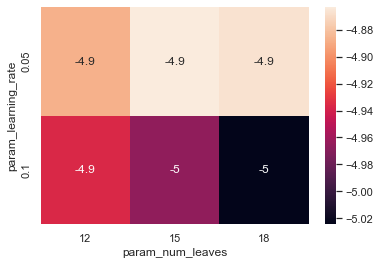

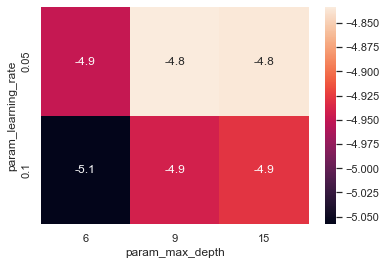

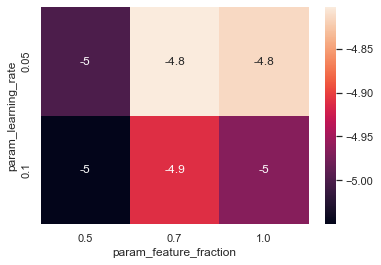

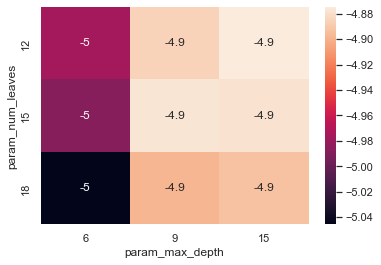

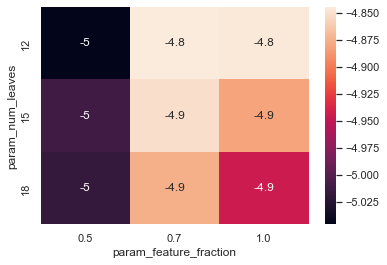

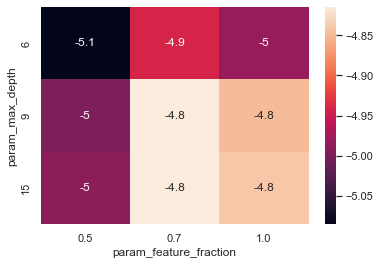

In [16]:
cv_result = pd.DataFrame(gsLGB.cv_results_)

for params in param_comb_list:
    plt.figure()

    cv_result_pivot = cv_result.pivot_table('mean_test_score', params[0], params[1])
    heat_map = sns.heatmap(cv_result_pivot, annot=True)

### 4.5 Plot learning curves
- Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

[0.1   0.325 0.55  0.775 1.   ]
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7


/Users/shuya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGB

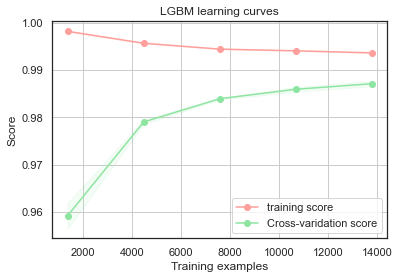

In [17]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve
    """
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    if ylim is not None:
        plt.ylim(*ylim)

    print(train_sizes)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    print(train_sizes)
    print(len(X))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    print(train_scores_std)
    print(test_scores_std)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-varidation score")

    plt.legend(loc="best")
    return plt

#g = plot_learning_curve(GBC_best, "GradientBoosting learning curves", X_train, Y_train, cv=kfold)
#g = plot_learning_curve(RFC_best, "RF learning curves", X_train, Y_train, cv=kfold)
#g = plot_learning_curve(XGB_best, "XGBoost learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(LGB_best, "LGBM learning curves", x_train, y_train, cv=kfold)

### 4.6 Feature importance

,LightGBM
0,day
1,month
2,dayofweek
3,year
4,store_KaggleMart
5,product_Kaggle Hat


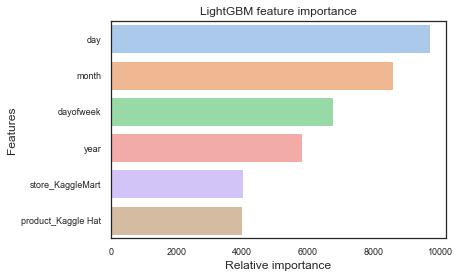

In [18]:
# name_models = {"RandomForest": RFC_best, "GradientBoosting": GBC_best, "XGBoost": XGB_best, "LightGBM": LGB_best}
name_models = {"LightGBM": LGB_best}
indices_num = 6

df_indices = pd.DataFrame(np.zeros((indices_num, len(name_models))), columns=name_models.keys())

for key in name_models:
    plt.figure()

    classifier = name_models[key]
    indices = np.argsort(classifier.feature_importances_)[::-1][:indices_num]

    df_indices[key] = X_train.columns[indices][:indices_num]

    g = sns.barplot(x=classifier.feature_importances_[indices][:indices_num], y=X_train.columns[indices][:indices_num], orient="h")

    g.set_xlabel("Relative importance", fontsize=12)
    g.set_ylabel("Features", fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(key + " feature importance")

df_indices

## 4. Prediction

In [19]:
num_sold = pd.Series(LGB_best.predict(test), name='num_sold')
submission_data = pd.concat([test_id, num_sold], axis=1)

#submission_data.loc[:, 'num_sold'] = submission_data['num_sold'] * 1.2097459848429086
submission_data = submission_data.astype(int)
submission_data

,row_id,num_sold
0,26298,417
1,26299,621
2,26300,174
3,26301,696
4,26302,1056
...,...,...
6565,32863,810
6566,32864,243
6567,32865,973
6568,32866,1427


## 5. save submission data

## Submit memo
- 20220120(1st try)
    - cross_validate, grid_search
    - best score in training
        ```
        Best Score: -6.462599703294936
        Best Param: {'feature_fraction': 1, 'learning_rate': 0.05, 'max_depth': 15, 'num_leaves': 31}
        ```
    - submittion score in kaggle
        ```
        6.81593 (ranking: 522/1099)
        ```
    - 所感
        - 結果の出方としては大体合ってるかな。
            - 評価指標の計算方法としては、問題なさそう。
        - feature importanceをみると、月日を重要視している。
            - これがいいのか悪いのか、微妙なところ
            - 年ごとの売り上げの違いとか、見た方がいいのかな
            - 月日がなかった場合の結果は、かなり変わるのかな
- 20220121(2nd try)
    - dataset(train_v1_label)
    - 1st tryと比較して、yearが含まれている
    - best score in training
        ```
        Best Score: -4.790924585595864
        Best Param: {'feature_fraction': 1, 'learning_rate': 0.05, 'max_depth': 15, 'num_leaves': 15}
        ```
    - submittion score in kaggle
        ```
        7.08564
        ```
    - 所感
        - すごい差がでた
        - 2018までしかyearのデータがないところに、2019だから、開きが出ている気がする
- 20220121(3rd try)
    - dataset(train_v2_onehot)
    - best score in training
        ```
        Best Score: -4.744143608687899
        Best Param: {'feature_fraction': 1, 'learning_rate': 0.05, 'max_depth': 15, 'num_leaves': 15}
        ```
    - submittion score in kaggle
        ```
        7.20024
        ```
    - 所感
        - すごい差がでた
        - 2018までしかyearのデータがないところに、2019だから、開きが出ている気がする
        - 時系列データのバリデーション対策が最優先に思う
- 20220121(4th try)
    - dataset(train_v3_onehot_economy)
    - best score in training
        ```
        Best Score: -4.71407153963216
        Best Param: {'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 15}
        ```
    - submittion score in kaggle
        ```
        9.88493
        ```
    - 所感
        - すごい差がでた
        - 2018までしかyearのデータがないところに、2019だから、開きが出ている気がする
        - 時系列データのバリデーション対策が最優先に思う






In [ ]:
os.makedirs("../data/submission/", exist_ok=True)
submission_data.to_csv("../data/submission/20220120_LGBM.csv", index=False)

In [ ]:
os.makedirs("../data/submission/", exist_ok=True)
submission_data.to_csv("../data/submission/20220121_v1_CVGS.csv", index=False)

In [ ]:
os.makedirs("../data/submission/", exist_ok=True)
submission_data.to_csv("../data/submission/20220121_v2_CVGS.csv", index=False)

In [ ]:
os.makedirs("../data/submission/", exist_ok=True)
submission_data.to_csv("../data/submission/20220121_v3_CVGS.csv", index=False)

In [ ]:
test.head()

### 3.2 Hyperparameter tunning for best models

In [ ]:
for i in range(N_trials):
    print(f"Trial {i+1}")
    random_state = random.randint(0, 1000)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    for reg_name, reg in reg_dict.items():
        reg.fit(x_train,y_train)
        y_pred = reg.predict(x_test)
        mape = mean_absolute_percentage_error(y_test, y_pred)  # MAPEを算出
        mape_dict[reg_name].append(mape)  # 格納

In [ ]:
LGB_best.evals_result()

### 3.5 Ensemble modeling

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('gbc', GBC_best), ('xgb', XGB_best), ('lgb', LGB_best)], voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train, Y_train)

In [ ]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')

submission_data = pd.concat([IDtest, test_Survived], axis=1)

submission_data

## 6. check difference (extra)

In [ ]:
df_20220110 = pd.read_csv("../data/submission/20220110_ensemble_RF_GB.csv", index_col=0)
df_20220113 = pd.read_csv("../data/submission/20220113_ensemble_RF_GB_XGB_LGBM.csv", index_col=0)

In [ ]:
df_20220110[(df_20220110 == df_20220113).all(axis=1) == False]